# Homework Assignment #02
## Global and Local Alignments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Problem 1. Global alignment

Implement global alignment algorithm. Two sequences are given as input, best alignment are outputed. Fixed penalty for mismatches and gaps is 1.

In [2]:
s1 = 'GATTACA'
s2 = 'GCATGCU'

def plot_alignment_matrix(matrix, path, score, figsize_scale=0.5):
    """Plot heatmap of alignment matrix with corresponding visual path reconstuction. """
    # Path matrix as binary matrix
    path_matrix = np.zeros(matrix.shape)
    for (i, j) in path:
        path_matrix[i, j] = 1
    
    fig, axs = plt.subplots(ncols=2, figsize=(matrix.shape[1]*2 * figsize_scale, matrix.shape[0] * figsize_scale))
    axs[0].set_title(f'Score: {score}')
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", ax=axs[0], cbar=False, xticklabels=False, yticklabels=False)
    axs[1].set_title("Path")
    sns.heatmap(path_matrix, annot=False, ax=axs[1], cbar=False, xticklabels=False, yticklabels=False)
    

def align_global(s1, s2, beta=1, mu=1):
    """
    s1 - string alongside rows of the alignment matrix
    s2 - string alongside columns of the alignment matrix
    beta - gap penalty (positive number, as it will be subtracted)
    mu - mismatch penalty (positive number, as it will be subtracted)
    
    Return: alignment matrix, s1 alignment, s2 alignment, reconstruction path
    """
    m = np.zeros((len(s1)+1, len(s2)+1))
    # First raw and column filled with initial beta penalties
    for i in range(1, len(s1)+1):
        m[i, 0] = m[i-1, 0] - beta
    for j in range(1, len(s2)+1):
        m[0, j] = m[0, j-1] - beta
        
    # Fill matrix raw by raw
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            match_penalty = [-mu, 1][s1[i-1] == s2[j-1]]
            m[i, j] = max(
                m[i-1, j-1] + match_penalty,
                m[i, j-1] - beta,
                m[i-1, j] - beta
            )
                        
    # Reconstruct alignment
    s1_aligned = ''
    s2_aligned = ''
    path = [(len(s1), len(s2))]
    i, j = len(s1), len(s2)
    while (i > 0 or j > 0):
        score = m[i, j]
        # max_prev_score = max(m[i-1, j], m[i, j-1], m[i-1, j-1])
        if score == m[i-1, j-1]  + [-mu, 1][s1[i-1] == s2[j-1]]:
            s1_aligned = s1[i-1] + s1_aligned
            s2_aligned = s2[j-1] + s2_aligned
            i -= 1; j -= 1
        elif score == m[i-1, j] - beta :
            s2_aligned = '-' + s2_aligned
            s1_aligned = s1[i-1] + s1_aligned
            i -= 1
        else:
            s1_aligned = '-' + s1_aligned
            s2_aligned = s2[j-1] + s2_aligned
            j -= 1
        path.insert(0, (i, j))
                
    return m, s1_aligned, s2_aligned, path

## Test 1

S1:  G-ATTACA
S2:  GCA-TGCU


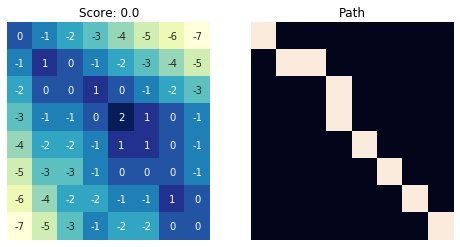

In [3]:
matrix, s1_align, s2_align, path = align_global(s1, s2)
print("S1: ", s1_align)
print("S2: ", s2_align)
plot_alignment_matrix(matrix, path, score=matrix[-1, -1])

S1:  эска--латор
S2:  -траволатор


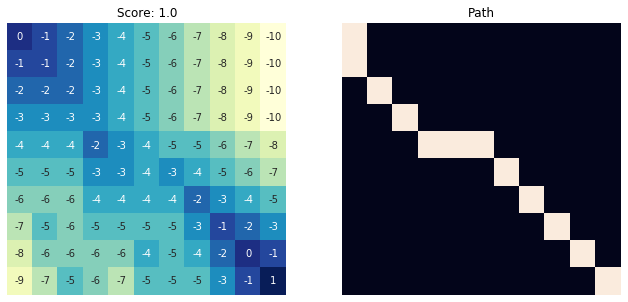

In [4]:
matrix, s1_align, s2_align, path = align_global('эскалатор', 'траволатор')
print("S1: ", s1_align)
print("S2: ", s2_align)
plot_alignment_matrix(matrix, path, score=matrix[-1,-1])

### Test 2

S1:  G-AT--TACA
S2:  GCATGCT---


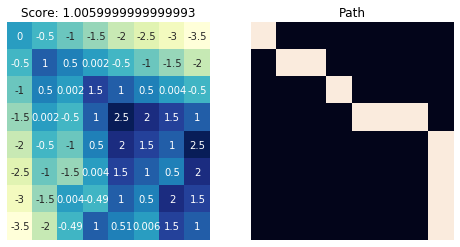

In [5]:
matrix, s1_align, s2_align, path = align_global('GATTACA', 'GCATGCT', beta=0.499, mu=1)
print("S1: ", s1_align)
print("S2: ", s2_align)
plot_alignment_matrix(matrix, path, score=matrix[-1, -1])

S1:  --эска--латор
S2:  тр---аволатор


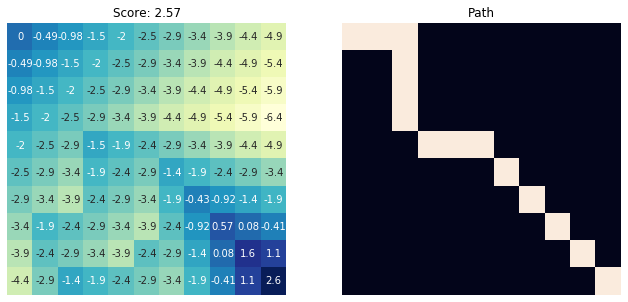

In [6]:
matrix, s1_align, s2_align, path = align_global('эскалатор', 'траволатор', beta=0.49, mu=1)
print("S1: ", s1_align)
print("S2: ", s2_align)
plot_alignment_matrix(matrix, path, score=matrix[-1, -1])

Gap with 0.499 penalty makes algorithm to prefer gaps over mismatches (-gap-gap > mimatch-gap), so resulting alignmnent consists only from matches and gaps.

## Problem 2. Global alignment with penalty weight matrix

In [7]:
def align_global_with_matrix(s1, s2, penalty_matrix, alphabet='ACGT-'):
    """
    s1 - string alongside rows of the alignment matrix
    s2 - string alongside columns of the alignment matrix
    pentalty_matrix - numpy matrix with penalty wegiths, 
        where raws and columns correspond to the alphabet
    alphabet - string of possible symbols
    """
    m = np.zeros((len(s1)+1, len(s2)+1))
    
    def get_penalty(c1, c2):
        return penalty_matrix[alphabet.index(c1), alphabet.index(c2)]
    
    # First raw and column filled with beta penalties
    for i in range(1, len(s1)+1):
        m[i, 0] = m[i-1, 0] - get_penalty(s1[i-1], '-')
    for j in range(1, len(s2)+1):
        m[0, j] = m[0, j-1] - get_penalty('-', s2[j-1])
        
    # Fill matrix raw by raw
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(
                m[i-1, j-1] - get_penalty(s1[i-1], s2[j-1]),
                m[i, j-1] - get_penalty('-', s2[j-1]),
                m[i-1, j] - get_penalty(s1[i-1], '-')
            )
                        
    # Reconstruct alignment
    s1_aligned = ''
    s2_aligned = ''
    path = [(len(s1), len(s2))]
    i, j = len(s1), len(s2)
    while i > 0 or j > 0:
        score = m[i, j]
        if score == m[i-1, j-1] - get_penalty(s1[i-1], s2[j-1]):
            s1_aligned = s1[i-1] + s1_aligned
            s2_aligned = s2[j-1] + s2_aligned
            i -= 1
            j -= 1
        elif score == m[i-1, j] - get_penalty(s1[i-1], '-'):
            s2_aligned = '-' + s2_aligned
            s1_aligned = s1[i-1] + s1_aligned
            i -= 1
        else:
            s1_aligned = '-' + s1_aligned
            s2_aligned = s2[j-1] + s2_aligned
            j -= 1
        path.insert(0, (i, j))
                
    return m, s1_aligned, s2_aligned, path

### Test

Let's set penalties matrix corresponding to beta=1, mu=1, alignment should be the same as in the previous problem

In [8]:
# ACGT + gap
penalty_weights = np.array([
    [-1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, -1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, -1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, -1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])

matrix, s1_align, s2_align, path = align_global_with_matrix('GATTACA', 'GCATGCT', penalty_weights)
print("S1: ", s1_align)
print("S2: ", s2_align)
print("Score: ", matrix[-1,-1])

S1:  G-ATTACA
S2:  GCA-TGCT
Score:  0.0


Now let's consider CCCACCC vs. CCCGCCC alignment. First time set A-G penalty low, second time - very high.

In [9]:
penalty_weights = np.array([
    [-1.0, 1.0, 0.1, 1.1, 0.1],
    [1.0, -1.0, 1.0, 1.0, 0.1],
    [0.1, 1.0, -1.0, 1.0, 0.1],
    [1.1, 1.0, 1.0, -1.0, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1]
])

matrix, s1_align, s2_align, path = align_global_with_matrix('CCCACCC', 'CCCGCCC', penalty_weights)
print("S1: ", s1_align)
print("S2: ", s2_align)
print("Score: ", matrix[-1,-1])

S1:  CCCACCC
S2:  CCCGCCC
Score:  5.9


In [10]:
penalty_weights = np.array([
    [-1.0, 1.0, 10.0, 1.1, 0.1],
    [1.0, -1.0, 1.0, 1.0, 0.1],
    [10.0, 1.0, -1.0, 1.0, 0.1],
    [1.1, 1.0, 1.0, -1.0, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1]
])

matrix, s1_align, s2_align, path = align_global_with_matrix('CCCACCC', 'CCCGCCC', penalty_weights)
print("S1: ", s1_align)
print("S2: ", s2_align)
print("Score: ", matrix[-1,-1])

S1:  CCC-ACCC
S2:  CCCG-CCC
Score:  5.8


It can be seen that in the second example such alignment was chosen so that A-G mismatch was not encountered

## Problem 3. Local Alignment

In [11]:
def align_local(s1, s2, penalty_matrix, alphabet='ACGT-'):
    """
    s1 - string alongside rows of the alignment matrix
    s2 - string alongside columns of the alignment matrix
    penalty_matrix - numpy matrix with weight penalties
    alphabet - string of possible symbols
    """
    m = np.zeros((len(s1)+1, len(s2)+1))
    
    def get_penalty(c1, c2):
        return penalty_matrix[alphabet.index(c1), alphabet.index(c2)]
        
    # Fill matrix raw by raw
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(
                0,
                m[i-1, j-1] - get_penalty(s1[i-1], s2[j-1]),
                m[i, j-1] - get_penalty('-', s2[j-1]),
                m[i-1, j] - get_penalty(s1[i-1], '-')
            )
                                    
    # Reconstruct alignment
    i, j = np.argmax(m) // m.shape[1], np.argmax(m) % m.shape[0]
    s1_end, s2_end = i, j
    score = m[i, j]    
    s1_aligned = ''
    s2_aligned = ''
    
    path = [(i, j)]
    find_local = False
    while (i > 0 or j > 0):
        # Local alignment break
        if max(m[i-1, j-1], m[i-1, j], m[i, j-1]) == 0:
            if m[i-1, j-1] == 0:
                find_local = True
                s1_aligned = s1[i-1] + s1_aligned
                s2_aligned = s2[j-1] + s2_aligned
                i -= 1; j -= 1
            elif m[i-1, j] == 0:
                find_local = True
                s1_aligned = s1[i-1] + s1_aligned
                s2_aligned = '-' + s2_aligned
                i -= 1
            else:
                find_local = True
                s1_aligned = '-' + s1_aligned
                s2_aligned = s2[j-1] + s2_aligned
                j -= 1
        # Standard reconstruction
        else:
            if m[i, j] == m[i-1, j-1] - get_penalty(s1[i-1], s2[j-1]):
                s1_aligned = s1[i-1] + s1_aligned
                s2_aligned = s2[j-1] + s2_aligned
                i -= 1; j -= 1
            elif m[i, j] == m[i-1, j] - get_penalty(s1[i-1], '-'):
                s2_aligned = '-' + s2_aligned
                s1_aligned = s1[i-1] + s1_aligned
                i -= 1
            else:
                s1_aligned = '-' + s1_aligned
                s2_aligned = s2[j-1] + s2_aligned
                j -= 1
            
        path.insert(0, (i, j))
        if find_local:
            break     
            
    # Fill existing symbols with '*' and shift with ' '
    s1_aligned += '*' * (m.shape[0]-1-s1_end)
    s2_aligned += '*' * (m.shape[1]-1-s2_end)
    s1_aligned = '*' * i + s1_aligned
    s2_aligned = '*' * j + s2_aligned
    if j == 0:
        s2_aligned = ' ' * i + s2_aligned
    elif i == 0:
        s1_aligned = ' ' * j + s1_aligned
        
    return m, s1_aligned, s2_aligned, path, score

### Test

Let's inject 'ACGTACGT' subsequence into two of DNA-strings, then local alignment must identify it

S1: ******ACGTACGT
S2:       ACGTACGT******
Score:  8.0


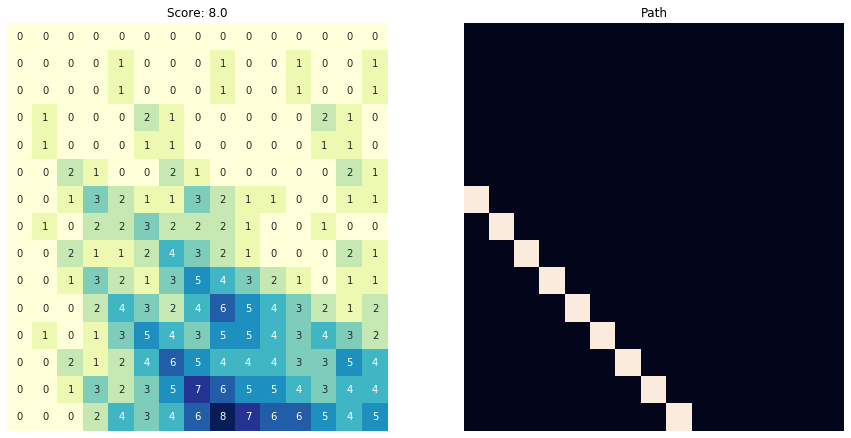

In [12]:
# ACGT + gap
penalty_weights = np.array([
    [-1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, -1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, -1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, -1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0]
])
s1 = 'TTAACGACGTACGT'
s2 = 'ACGTACGTGGTACT'
matrix, s1_aligned, s2_aligned, path, score = align_local(s1, s2, penalty_weights)

print(f"S1: {s1_aligned}")
print(f"S2: {s2_aligned}")
print("Score: ", score)
plot_alignment_matrix(matrix, path, score)

Global alignment on the other hand will not find this short subsequence

S1:  --TTAACGACGTACGT
S2:  ACGT-ACGTGGTAC-T
Score:  2.0


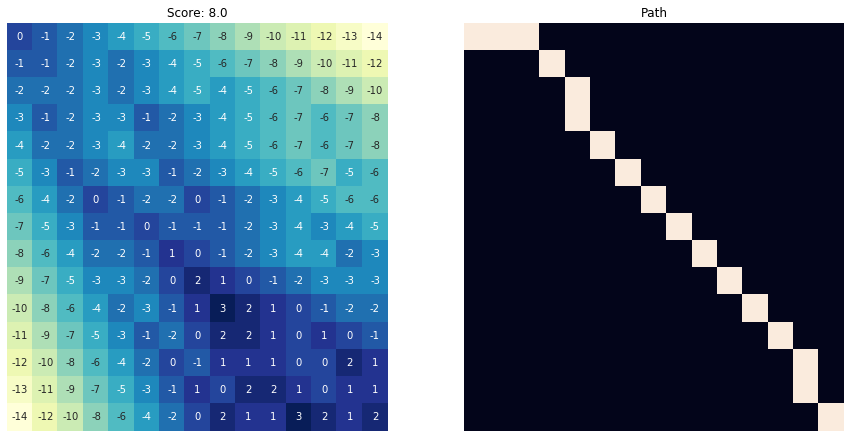

In [13]:
matrix, s1_align, s2_align, path = align_global_with_matrix(s1, s2, penalty_weights)
print("S1: ", s1_align)
print("S2: ", s2_align)
print("Score: ", matrix[-1,-1])
plot_alignment_matrix(matrix, path, score)